In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
import numpy as np
from kymatio import Scattering2D
from skimage import measure

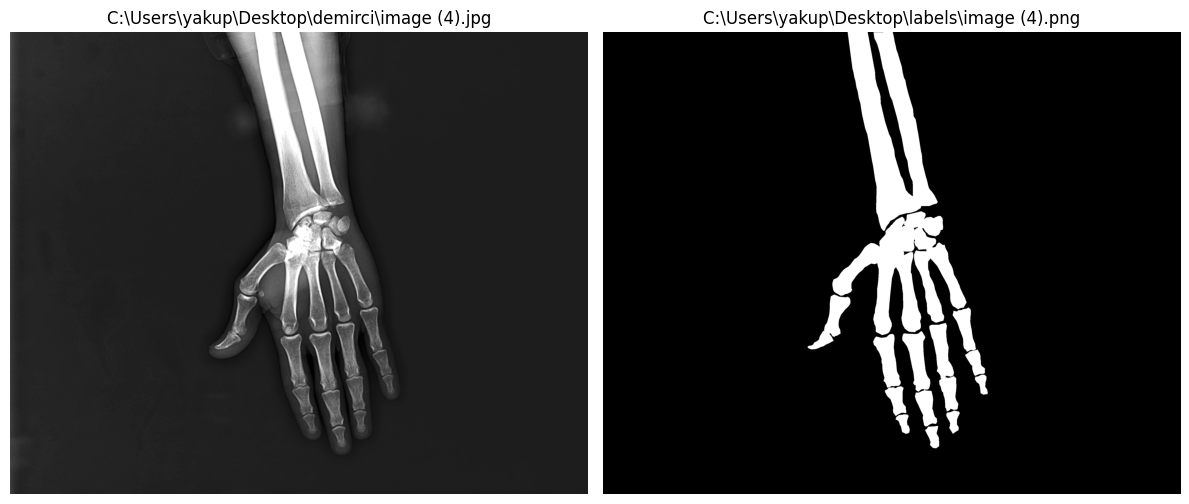

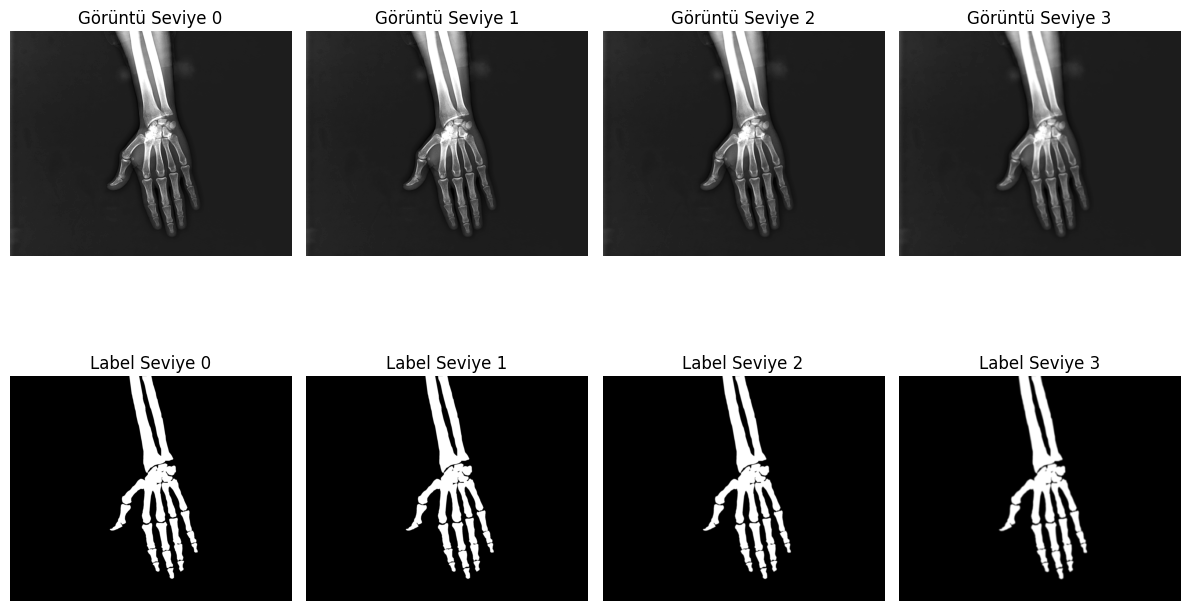

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def ConvertAndNormalize(img, apply_preprocessing=True):
    # Eğer görüntü renkli ise gri tonlamaya çevir
    if len(img.shape) == 3 and img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # I1 Norm Normalizasyonu
    normalized_image = img / 255.0  # Piksel değerlerini [0, 1] aralığına getir
    normalized_image = (normalized_image * 255).astype(np.uint8)  # [0, 255] aralığına geri çevir
    
    # Keskinleştirme (Unsharp Masking)
    if apply_preprocessing:
        # Ortalama (Mean) Filtreleme
        def mean_filter(image, kernel_size=5):
            return cv2.blur(image, (kernel_size, kernel_size))  # Ortalama filtre uygula

        mean_filtered = mean_filter(normalized_image, kernel_size=5)

        # Ön işleme işlemleri 
        brightness_increase = 20  # Parlaklık artırma miktarı
        brightened_image = cv2.add(mean_filtered, np.full_like(mean_filtered, brightness_increase))

        # Parlaklık Artırma
        def sharpen_image(image):
            blurred = cv2.GaussianBlur(image, (5, 5), 1.5)  # Gaussian blur uygula
            sharpened = cv2.addWeighted(image, 1.5, blurred, -0.5, 0)  # Keskinleştirme işlemi
            return sharpened

        sharpened_image = sharpen_image(brightened_image)
    
    # Normalize edilmiş görüntü döndürülür
    return sharpened_image

def GetImageLabel(imgStr, labelStr, draw=False):
    img = cv2.imread(imgStr, cv2.IMREAD_GRAYSCALE); img = ConvertAndNormalize(img)
    label = cv2.imread(labelStr, cv2.IMREAD_GRAYSCALE)        
    if draw:
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.title(imgStr)
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(label, cmap='gray')
        plt.title(labelStr)
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()  
    return img, label

# img ve label gorselleri al
img, label = GetImageLabel(
    r"C:\Users\yakup\Desktop\demirci\image (4).jpg",
    r"C:\Users\yakup\Desktop\labels\image (4).png",
    draw=True
)

# Gauss piramidi oluşturma fonksiyonu
def create_gaussian_pyramid(image, levels=3):
    pyramid = [image]
    for _ in range(levels):
        image = cv2.pyrDown(image)  # Görüntüyü yarıya indir
        pyramid.append(image)
    return pyramid

# img ve label üzerinde Gauss piramidi oluştur
img_pyramid = create_gaussian_pyramid(img, levels=3)
label_pyramid = create_gaussian_pyramid(label, levels=3)

# Piramit seviyelerini ayrı değişkenlerde saklama
img_level_0, img_level_1, img_level_2, img_level_3 = img_pyramid
label_level_0, label_level_1, label_level_2, label_level_3 = label_pyramid

# Sonuçları görselleştirme
plt.figure(figsize=(12, 8))
for level, (pyr_img, pyr_label) in enumerate(zip(img_pyramid, label_pyramid)):
    plt.subplot(2, 4, level + 1)
    plt.imshow(pyr_img, cmap='gray')
    plt.title(f'Görüntü Seviye {level}')
    plt.axis('off')

    plt.subplot(2, 4, level + 5)
    plt.imshow(pyr_label, cmap='gray')
    plt.title(f'Label Seviye {level}')
    plt.axis('off')

plt.tight_layout()
plt.show()




In [5]:
#Görüntü Seviye 2 'yi kullanarak desen kodla aşamalarından birini uygulayalım.

In [6]:
#yazdırma

In [7]:
def Drawing(img, EdgePoints=None, EdgeLines=None, EdgePatchs=None, title=None, circle_radius=10):
    output_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)    
       
    if EdgePoints is not None:         
        for point in EdgePoints:
            x, y = int(point[1]), int(point[0])  # x ve y koordinatları ters çevrilir
            cv2.circle(output_img, (x, y), circle_radius, (0, 0, 255), -1)  # Kırmızı daire   

    if EdgeLines is not None: 
        for Line in EdgeLines:
            start_point = Line["StartPointYX"]
            stop_point = Line["StopPointYX"]
            cv2.line(output_img, start_point[::-1], stop_point[::-1], color=(255, 255, 0), thickness=2)                                

    if EdgePatchs is not None: 
        # Img üzerine Patch çiz
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 1
        color = (255, 0, 0)  
        thickness = 2
        for k, (x, y, PatchSize) in enumerate(EdgePatchs):  # (x, y, PatchSize) bekleniyor
            top_left = (x - PatchSize, y - PatchSize)
            bottom_right = (x + PatchSize, y + PatchSize)
            cv2.rectangle(output_img, top_left, bottom_right, (0, 0, 255), 2)
            cv2.putText(output_img, str(k), (x, y - 10), font, font_scale, color, thickness, cv2.LINE_AA)    

    # Görüntü boyutlarına göre figsize hesaplama
    height, width = img.shape[:2]
    aspect_ratio = width / height
    figsize = (15 * aspect_ratio, 15)  # Oranı koruyarak uygun bir ölçekleme

    plt.figure(figsize=figsize)
    plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
    if title is not None:
        plt.title(title, fontsize=30)
    plt.axis('off')
    plt.show()


In [5]:
#level 2 piramit

In [ ]:
#GÖRSELDEN PİKSELLER ALINMASI (SEYRELTİLEREK)

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def GetNonBlackPixels(img, sparsity_factor=1, draw=False, circle_radius=10):
    """
    Siyah olmayan pikselleri alır.
    Args:
        img: Giriş görüntüsü (tek kanallı).
        sparsity_factor: Piksel seyrekleştirme faktörü.
        draw: Piksel noktalarını çizmek isteyip istemediğiniz.
        circle_radius: Çizim sırasında noktaların yarıçapı.
    Returns:
        pixels: Siyah olmayan piksellerin (y, x) koordinatları.
    """
    # Siyah olmayan piksellerin koordinatlarını al
    y, x = np.where(img > 0)
    pixels = np.vstack((y, x)).T  # (y, x) -> [[y1, x1], [y2, x2], ...]

    # Sparsity factor ile seyrekleştirme
    if sparsity_factor > 1:
        pixels = pixels[::sparsity_factor]

    # Çizim yapmak istenirse
    if draw:
        Drawing(img, EdgePoints=pixels, circle_radius=circle_radius)

    return pixels

# Görselleri ve isimlerini listeleyin
masked_images = [masked_image, masked_image2, masked_image3]
image_titles = ["Masked Image 1", "Masked Image 2", "Masked Image 3"]

# Noktalar işaretlenmiş görselleri tutmak için
point_masked_images1 = masked_image.copy()
point_masked_images2 = masked_image2.copy()
point_masked_images3 = masked_image3.copy()

# Görselleştirme
plt.figure(figsize=(15, 5))

# Her bir görüntü için noktaları işaretleyin
for i, masked_image in enumerate(masked_images):
    # Siyah olmayan pikselleri al ve noktaları çiz
    if i == 0:
        img_Points1 = GetNonBlackPixels(point_masked_images1, sparsity_factor=300, circle_radius=10, draw=True)
    elif i == 1:
        img_Points2 = GetNonBlackPixels(point_masked_images2, sparsity_factor=300, circle_radius=10, draw=True)
    elif i == 2:
        img_Points3 = GetNonBlackPixels(point_masked_images3, sparsity_factor=300, circle_radius=10, draw=True)

    # Görselleştirme
    plt.subplot(1, 3, i + 1)
    plt.imshow(masked_image, cmap='gray')
    plt.title(f"{image_titles[i]} - Noktalar")
    plt.axis('off')

plt.tight_layout()
plt.show()

NameError: name 'masked_image' is not defined

In [6]:
def GetLabelEdgePoints(img, sparsity_factor=1, circle_radius=10, draw=False, title=None):
    contours = measure.find_contours(img, level=0.5)
    # Tüm sınır piksellerini birleştir
    boundary_points = np.vstack(contours)
    
    # Sparsity factor ile seyrekleştirme
    if sparsity_factor > 1:
        boundary_points = boundary_points[::sparsity_factor]
        
    if draw:
        Drawing(img, EdgePoints=boundary_points, circle_radius=circle_radius, title=title)

    return boundary_points.astype(int)

# Kenar Gorsellerini Kodla
title = "Label Level 1 - kenar noktası"
img_EdgePoints = GetLabelEdgePoints(label_level_1, sparsity_factor=30, circle_radius=10, draw=True, title=title)


NameError: name 'measure' is not defined

In [13]:
#pach alıyoruz

In [15]:
def Drawing(img, EdgePoints, EdgePatchs=None, circle_radius=10):
    """
    Görüntü üzerine belirtilen noktaları ve patch sınırlarını çizen fonksiyon
    """
    if len(img.shape) == 2:  # Eğer görüntü tek kanallıysa
        img_copy = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    else:
        img_copy = img.copy()

    for point in EdgePoints:
        cv2.circle(img_copy, tuple(point[::-1]), circle_radius, (0, 0, 255), -1)  # Kırmızı nokta çizer

    if EdgePatchs is not None:
        for k, (x, y, PatchSize, angle) in enumerate(EdgePatchs):  # (x, y, PatchSize, angle)
            top_left = (int(x - PatchSize), int(y - PatchSize))
            bottom_right = (int(x + PatchSize), int(y + PatchSize))
            cv2.rectangle(img_copy, top_left, bottom_right, (255, 0, 0), 2)  # Mavi dikdörtgen çizer

    plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))  # Görüntüyü RGB olarak görselleştir
    plt.axis('off')
    plt.show()


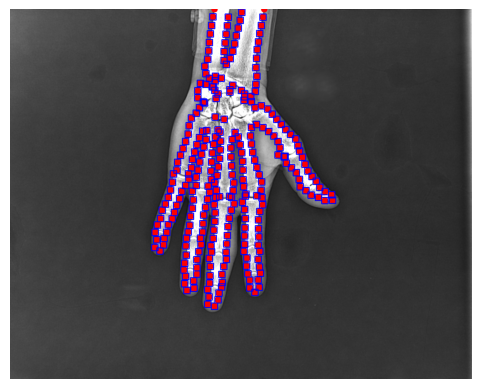

In [17]:
def GetEdgePatchs(img, EdgePoints, PatchSize=11, draw=True):
    EdgePatchs = []
    EdgePatchsInfo = []
    for i in range(len(EdgePoints)):
        # Çizginin başlangıç noktası
        y, x = EdgePoints[i]

        # Çizginin yönü
        prev_idx = (i - 1) % len(EdgePoints)
        next_idx = (i + 1) % len(EdgePoints)
        y1, x1 = EdgePoints[prev_idx]
        y2, x2 = EdgePoints[next_idx]
        dx = x2 - x1
        dy = y2 - y1
        if dx == 0 and dy == 0:
            continue  
        angle = math.atan2(-dx, dy)

        # Patch al
        center = (float(x), float(y))
        rotation_matrix = cv2.getRotationMatrix2D(center, np.degrees(angle), scale=1.0)
        rows, cols = img.shape
        rotated_image = cv2.warpAffine(img, rotation_matrix, (cols, rows), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
        # Patch sınırlarını kontrol et
        y_start, y_end = y - PatchSize, y + PatchSize + 1
        x_start, x_end = x - PatchSize, x + PatchSize + 1

        if y_start < 0 or y_end > rows or x_start < 0 or x_end > cols:
            # Patch görüntü sınırlarının dışında, atla
            continue
                
        EdgePatch = rotated_image[y-PatchSize:y+PatchSize+1, x-PatchSize:x+PatchSize+1]

        EdgePatchs.append(EdgePatch)
        EdgePatchsInfo.append([x,y,PatchSize,np.degrees(angle)])
    
    if draw:
        Drawing(img, EdgePoints=EdgePoints, EdgePatchs = EdgePatchsInfo)        
        
    return EdgePatchs, EdgePatchsInfo

# img_EdgePoints --> img_EdgePatchs 
img_EdgePatchs, img_EdgePatchsInfo = GetEdgePatchs(img_level_1, img_EdgePoints, PatchSize=10, draw=True)  # M = 2*PatchSize + 1,  MxM = 101x101

In [ ]:
#Toplam 274 patch HOG ile kodlandı.

In [20]:
import cv2
import numpy as np
import os
import math

# HOG özelliklerini hesaplayan fonksiyon
def compute_hog_features(image, cell_size=(8, 8), block_size=(2, 2), nbins=9):
    
    hog = cv2.HOGDescriptor(
        _winSize=(image.shape[1] // cell_size[1] * cell_size[1], 
                  image.shape[0] // cell_size[0] * cell_size[0]),
        _blockSize=(block_size[1] * cell_size[1], block_size[0] * cell_size[0]),
        _blockStride=(cell_size[1], cell_size[0]),
        _cellSize=(cell_size[1], cell_size[0]),
        _nbins=nbins
    )
    features = hog.compute(image)
    return features.flatten()

# HOG özelliklerini ve koordinatlarını kaydeden fonksiyon
def save_hog_features_with_coords(patches, patch_info, output_path, cell_size=(8, 8), block_size=(2, 2), nbins=9):
    
    all_features = []
    all_coords = []

    for i, (patch, info) in enumerate(zip(patches, patch_info)):
        features = compute_hog_features(patch, cell_size, block_size, nbins)
        all_features.append(features)
        all_coords.append(info)

        
    all_features = np.array(all_features)
    all_coords = np.array(all_coords)

    # Dosya yolu oluşturuluyor
    try:
        # Dizin yoksa oluşturuluyor
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        
        # HOG özellikleri ve koordinatları kaydediliyor
        np.savez(output_path, features=all_features, coords=all_coords)
        print(f"HOG özellikleri ve koordinatlar kaydedildi: {output_path}")
    except Exception as e:
        # Kaydetme sırasında oluşan hatayı yazdır
        print(f"Kaydetme sırasında hata oluştu: {e}")


# Görüntüyü ve kenar noktalarını al (img_level_1 değişkeni burada kullanılacak)
img = img_level_1  # img_level_1 burada kullanılıyor

# HOG özelliklerini kaydetme
output_file_with_coords = r"C:\Users\yakup\OneDrive\Desktop\piramit_1\hog_features_with_coords.npz"  # Masaüstü yolu

# Hata ayıklamak için görüntülerin ve patch'lerin doğru şekilde geçildiğini kontrol et
print(f"Patch sayısı: {len(img_EdgePatchs)}")
save_hog_features_with_coords(img_EdgePatchs, img_EdgePatchsInfo, output_file_with_coords)

# Sonuç olarak toplam kaç patch kodlandığını yazdır
print(f"Toplam {len(img_EdgePatchs)} patch HOG ile kodlandı.")


Patch sayısı: 274
HOG özellikleri ve koordinatlar kaydedildi: C:\Users\yakup\OneDrive\Desktop\piramit_1\hog_features_with_coords.npz
Toplam 274 patch HOG ile kodlandı.


In [21]:
#test aşaması

In [22]:
#ön işleme

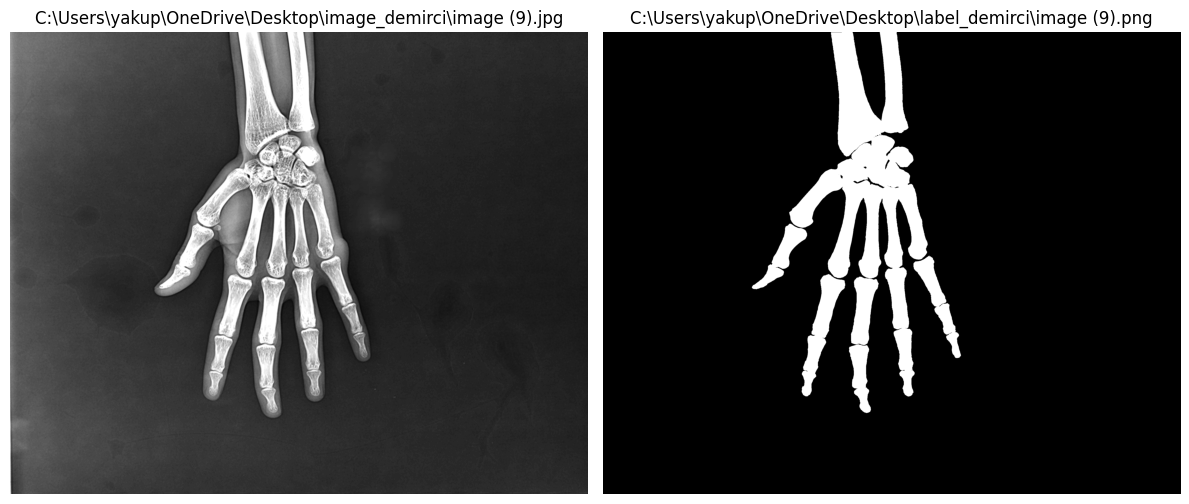

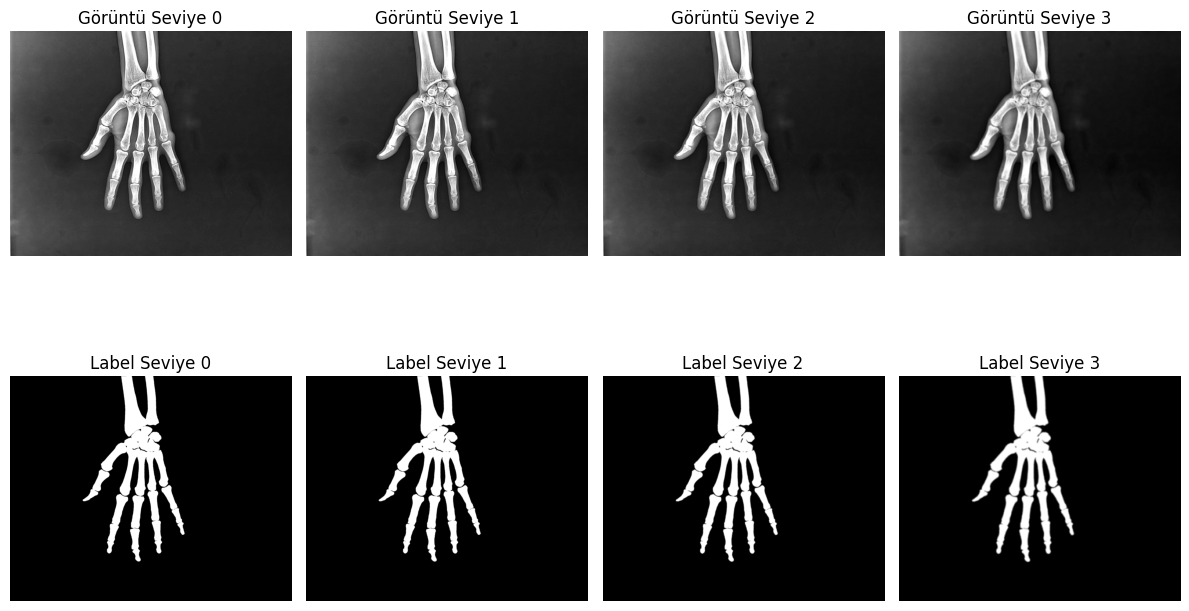

In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def ConvertAndNormalize(img, apply_preprocessing=True):
    # Eğer görüntü renkli ise gri tonlamaya çevir
    if len(img.shape) == 3 and img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # I1 Norm Normalizasyonu
    normalized_image = img / 255.0  # Piksel değerlerini [0, 1] aralığına getir
    normalized_image = (normalized_image * 255).astype(np.uint8)  # [0, 255] aralığına geri çevir
    
    # Ön işleme işlemleri
    if apply_preprocessing:
        # Ortalama (Mean) Filtreleme
        def mean_filter(image, kernel_size=5):
            return cv2.blur(image, (kernel_size, kernel_size))  # Ortalama filtre uygula

        mean_filtered = mean_filter(normalized_image, kernel_size=5)

        # Parlaklık Artırma
        brightness_increase = 20  # Parlaklık artırma miktarı
        brightened_image = cv2.add(mean_filtered, np.full_like(mean_filtered, brightness_increase))

        # Keskinleştirme (Unsharp Masking)
        def sharpen_image(image):
            blurred = cv2.GaussianBlur(image, (5, 5), 1.5)  # Gaussian blur uygula
            sharpened = cv2.addWeighted(image, 1.5, blurred, -0.5, 0)  # Keskinleştirme işlemi
            return sharpened

        sharpened_image = sharpen_image(brightened_image)
    
    # Normalize edilmiş görüntü döndürülür
    return sharpened_image

def GetImageLabel(imgStr, labelStr, draw=False):
    img = cv2.imread(imgStr, cv2.IMREAD_GRAYSCALE); img = ConvertAndNormalize(img)
    label = cv2.imread(labelStr, cv2.IMREAD_GRAYSCALE)        
    if draw:
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.title(imgStr)
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(label, cmap='gray')
        plt.title(labelStr)
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()  
    return img, label

# img ve label gorselleri al
img, label = GetImageLabel(
    r"C:\Users\yakup\OneDrive\Desktop\image_demirci\image (9).jpg",
    r"C:\Users\yakup\OneDrive\Desktop\label_demirci\image (9).png",
    draw=True
)

# Gauss piramidi oluşturma fonksiyonu
def create_gaussian_pyramid(image, levels=3):
    pyramid = [image]
    for _ in range(levels):
        image = cv2.pyrDown(image)  # Görüntüyü yarıya indir
        pyramid.append(image)
    return pyramid

# img ve label üzerinde Gauss piramidi oluştur
img_pyramid = create_gaussian_pyramid(img, levels=3)
label_pyramid = create_gaussian_pyramid(label, levels=3)

# Piramit seviyelerini ayrı değişkenlerde saklama
test_img_level_0, test_img_level_1, test_img_level_2, test_img_level_3 = img_pyramid
test_label_level_0, test_label_level_1, test_label_level_2, test_label_level_3 = label_pyramid

# Sonuçları görselleştirme
plt.figure(figsize=(12, 8))
for level, (pyr_img, pyr_label) in enumerate(zip(img_pyramid, label_pyramid)):
    plt.subplot(2, 4, level + 1)
    plt.imshow(pyr_img, cmap='gray')
    plt.title(f'Görüntü Seviye {level}')
    plt.axis('off')

    plt.subplot(2, 4, level + 5)
    plt.imshow(pyr_label, cmap='gray')
    plt.title(f'Label Seviye {level}')
    plt.axis('off')

plt.tight_layout()
plt.show()




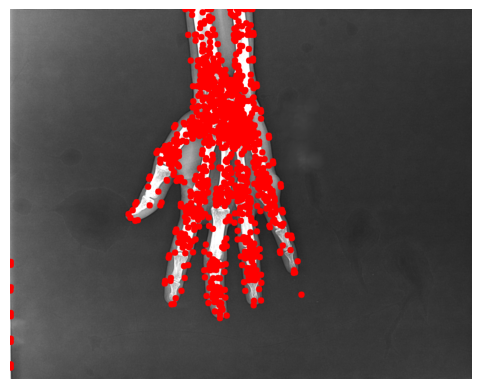

In [29]:
def GetCannyEdgePoints(img, sparsity_factor=1, draw=False):
    blurimg = cv2.GaussianBlur(img, (5, 5), 0)
    edges = cv2.Canny(blurimg, 25, 75)
    CannyEdgePoints, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    EdgePoints = []
    for ObjPoints in CannyEdgePoints:
        EdgePoints = EdgePoints + [(point[0][1], point[0][0]) for i, point in enumerate(ObjPoints) if i % sparsity_factor == 0]

    if draw:
        Drawing(img, EdgePoints=EdgePoints)

    return EdgePoints

test_img_EdgePoints = GetCannyEdgePoints(test_img_level_1, sparsity_factor=80, draw=True)   # EdgePoints --> [p,2] --> (y,x)